# Applied Data Analysis

## Fall Semester 2016

Team members:
* Stylianos Agapiou (stylianos.agapiou@epfl.ch)
* Athanasios Giannakopoulos (athanasios.giannakopoulos@epfl.ch)
* Dimitrios Sarigiannis (dimitrios.sarigiannis@epfl.ch)

## Project Description

We are given a dataset containing tweets in Switzerland starting from 2010. 

The first goal of the project is to analyse the data and reconstruct mobility flows of the users. More concretely, we try to get insights into high-frequency migration patterns in the swiss territory. The implementation is given in [mobility_patterns](mobility_patterns.ipynb). We also perform data analysis on aggregated data from all years that have been processed in the [mobility_patterns_aggregated](mobility_patterns_aggregated.ipynb) notebook.

The second task of the project is to detect events. Here, we focus on dates and locations of such events. The implementation in given in [event_detection](event_detection.ipynb).

The third and final part of the project deals with sentiment analysis. Here, we focus on the tweets linked to events (as detected in the [event_detection](event_detection.ipynb) notebook) and perform a sentiment analysis for each event. The implementation of the sentiment analysis is given in the [sentiment_analysis](sentiment_analysis.ipynb) notebook.

## Aggregated Mobility Patterns

This notebook focuses on the aggregated mobility pattern detection in Switzerland, i.e. for all years that have been analyzed. We use the <code>travel_info_year</code> files to present an aggregated analysis for all years. This notebook is complementary to the [mobility_patterns](mobility_patterns.ipynb) and contains same operations on the aggregated dataframe. More concretely, we use the aggregated data and extract information about:

* cantons of residence and workplace
* average time and distance to work
* radius of gyration

In [1]:
%matplotlib inline
from utils_mobility import *

### Data Loading

First, we load all the materialized views created from the [mobility_patterns](mobility_patterns.ipynb) notebook to build a singe dataframe that contains travel information about all years that have been analyzed.

In [2]:
travel_data = load_all_files('travel_info')
# a few entries contain NaN due to the google maps API requerst
travel_data.dropna(inplace=True)

### Visualization

#### Where people live and where they work

We show a plot that reveals where people live and where they work. This helps in revealing mobility information related to where people live and work in Switzerland. In some cases we see that some people work in Switzerland but live in other areas.

In order to visualize the results in a clear plot, we set a threshold. This threshold is a minimum value of people  that work and live in a pair of cantons for all years that have been analyzed. The lower the threshold, the more points (canton of residence, canton of workplace) will appear on the x axis. In case the canton of residence and the canton of the workplace are different, the x tick label appears in red.

In [3]:
# threshold value
threshold = 25

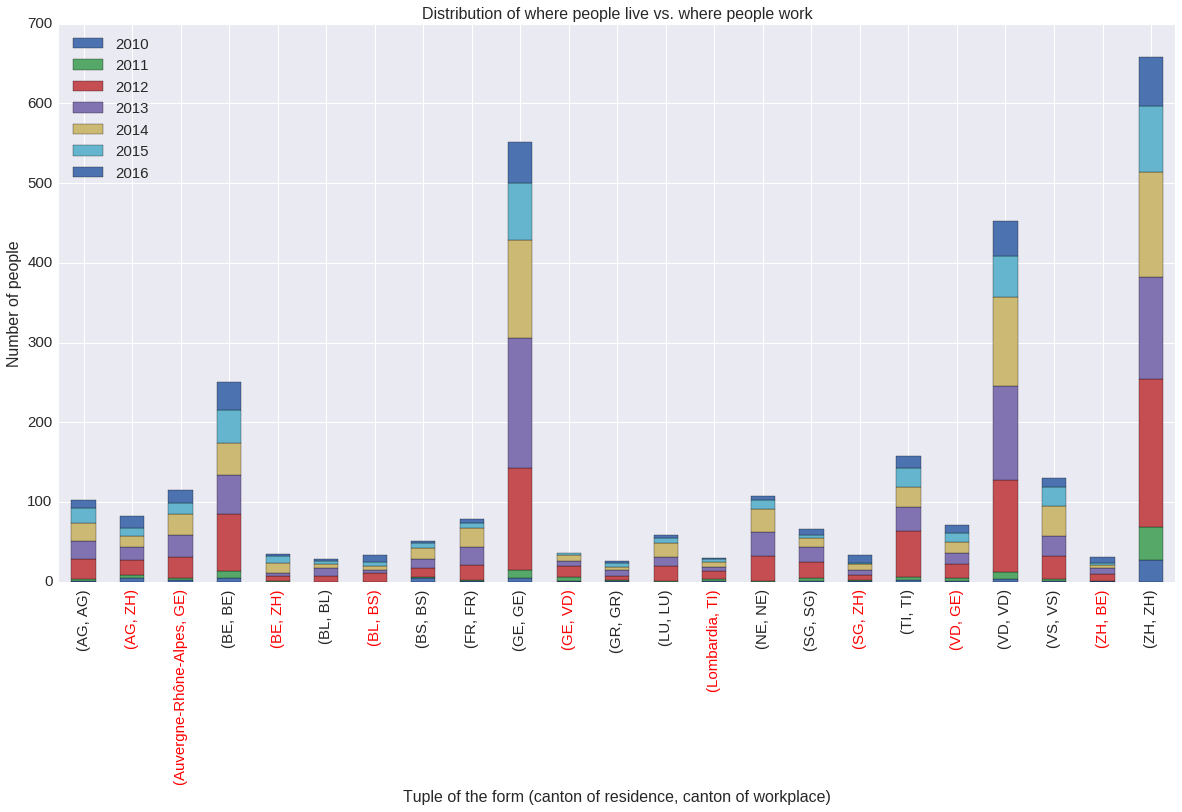

In [4]:
# groub by home and workplace cantons
travel_data_grouped = travel_data.groupby(by=['year', 'homeCanton', 'workCanton']).size().to_frame()
# use year as column
travel_data_grouped = travel_data_grouped.unstack('year').fillna(0.0)
# drop multiindex column
travel_data_grouped.columns = travel_data_grouped.columns.droplevel()
# create column for all years
travel_data_grouped['sum'] = travel_data_grouped.sum(axis=1)
# visualize with stacked bars
ax = travel_data_grouped[travel_data_grouped['sum'] > threshold].drop('sum', axis=1).plot(
    kind='bar', figsize=(20, 10), stacked=True)
# set display information
ax.set_xlabel('Tuple of the form (canton of residence, canton of workplace)', fontsize=16)
ax.set_ylabel('Number of people', fontsize=16)
ax.set_title('Distribution of where people live vs. where people work', fontsize=16)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(loc=2, prop={'size':15})
# set color for specific xticks
[label.set_color("red") for label in plt.gca().get_xticklabels() if different_canton(label.get_text())]
plt.savefig('../../data/figures/distribution_work_live', bbox_inches='tight')

#### People who work but do not live in Switzerland - Frontaliers

From the previous plot, it is clear that some people work in Switzerland but live in another country. Here, we filter out those that both work and live in Switzerland, and focus only on frontaliers, i.e. people who commute from other countries to Switzerland every day.

In [5]:
# file name
file_name = '../../data/swiss_cantons.pickle'
# load file
swiss_cantons = pickle.load(open(file_name, 'rb'))

We keep only entries that have at least a non swiss location.

In [6]:
non_swiss = travel_data_grouped.iloc[
    (~travel_data_grouped.index.get_level_values('homeCanton').isin(swiss_cantons.keys())) | 
    (~travel_data_grouped.index.get_level_values('workCanton').isin(swiss_cantons.keys()))]

In order to visualize the results in a clear plot, we set a threshold. Same as before, this threshold is a minimum value of people that work and live in a pair of cantons for all years that have been analyzed. The lower the threshold, the more points (canton of residence, canton of workplace) will appear on the x axis.

In [7]:
# threshold value
threshold = 3

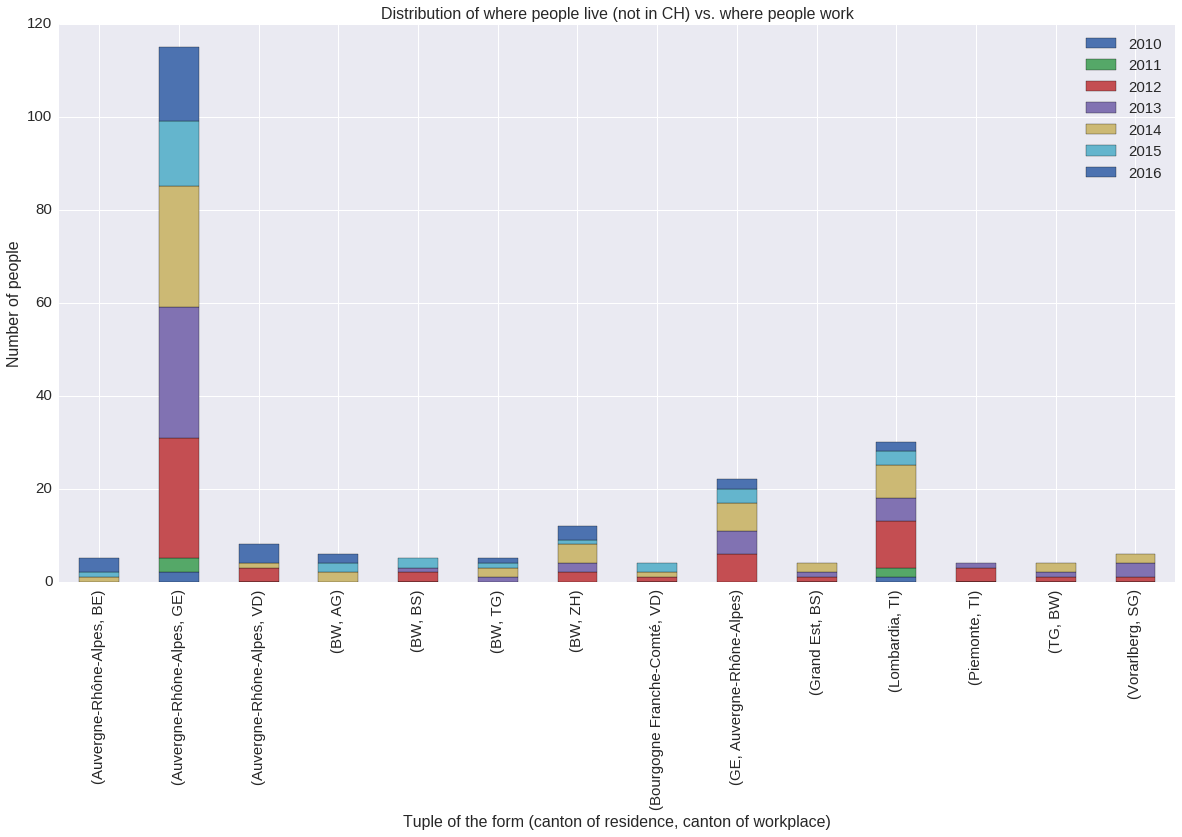

In [8]:
ax = non_swiss[non_swiss['sum'] > threshold].drop('sum', axis=1).plot(kind='bar', figsize=(20, 10), stacked=True)
# set display information
ax.set_xlabel('Tuple of the form (canton of residence, canton of workplace)', fontsize=16)
ax.set_ylabel('Number of people', fontsize=16)
ax.set_title('Distribution of where people live (not in CH) vs. where people work', fontsize=16)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(prop={'size':15})
plt.savefig('../../data/figures/distribution_work_live_non_swiss.png', bbox_inches='tight')

### Aggregated Time and Distance to Work

Also, we plot the distribution of the total distance and time needed for the users to reach their workplace. Here, we just take an average of the results contained in the materialized views. In other words, we take an average of the time and distance to work for each user, that we found after analyzing the dataset on a yearly basis.

In [9]:
avg_distance = travel_data[['userId', 'distance']].groupby(by='userId').mean()
avg_time = travel_data[['userId', 'time']].groupby(by='userId').mean()
avg_info = pd.concat([avg_distance, avg_time], axis=1)
avg_info.head(2)

,distance,time
userId,,
7173,1.511,5.40
11730,178.663,129.75


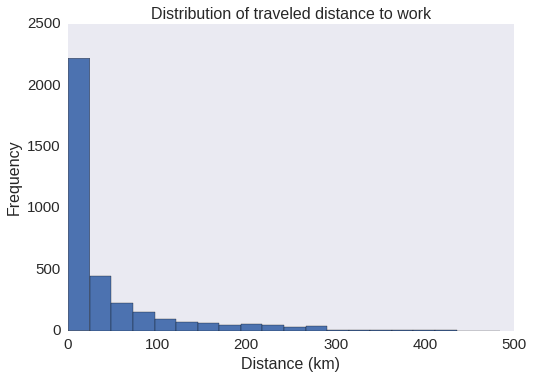

In [10]:
# plot distance distribution
plt.hist(avg_info['distance'], bins=20, range=(avg_info['distance'].min(), avg_info['distance'].max()))
# set display info
plt.title('Distribution of traveled distance to work', fontsize=16)
plt.xlabel('Distance (km)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.savefig('../../data/figures/avg_distance_to_work.png', bbox_inches='tight')

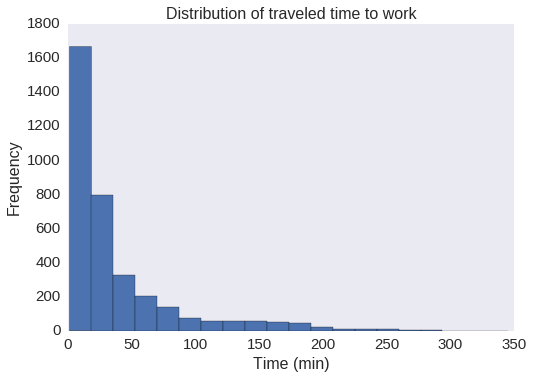

In [11]:
# plot time distribution
plt.hist(avg_info['time'], bins=20, range=(avg_info['time'].min(), avg_info['time'].max()))
# set display info
plt.title('Distribution of traveled time to work', fontsize=16)
plt.xlabel('Time (min)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.savefig('../../data/figures/avg_time_to_work.png', bbox_inches='tight')

Finally, we present the median distance and time to work:

In [12]:
print('The median distance is: {0:.2f} km'.format(avg_info['distance'].median()))
print('The median time is: {0:.2f} minutes'.format(avg_info['time'].median()))

The median distance is: 13.45 km
The median time is: 19.86 minutes


## Aggregated Radius of Gyration

### Data Loading

Here, we load all the materialized views created from the [mobility_patterns](mobility_patterns.ipynb) notebook to build a singe dataframe that contains gyration information about all years that have been analyzed.

In [13]:
# load all data into a single dataframe
gyration_info = load_all_files('gyration')

The definition and the way of estimating the radius of gyration is given in the [mobility_patterns](mobility_patterns.ipynb) notebook. Knowing that the radius of gyration is a kind of standard deviation, we use the [following formula](https://en.wikipedia.org/wiki/Pooled_variance) for aggregation: 
$$s_p^2 = \frac{\sum^k_{i=1}(n_i - 1)s_i^2}{\sum^k_{i=1}(n_i - 1)}$$

In [14]:
# apply formula and find average radius of gyration
avg_gyration = gyration_info.groupby(by='userId').apply(estimate_avg_gyration)

### Visualize Radius of Gyration

Now, we plot the distribution of the radius of gyration. This distribution gives a rough estimation of how much Swiss people travel. However, we have to point out that this **estimation depends on the given dataset**, i.e. we cannot drow any general conclusions that the majority of Swiss does not travel a lot. 

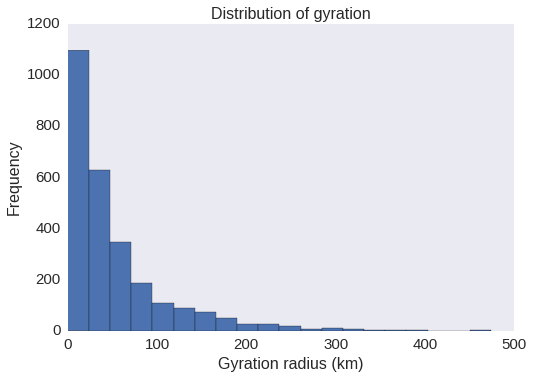

In [15]:
plt.hist(avg_gyration, bins=20)
plt.title('Distribution of gyration', fontsize=16)
plt.xlabel('Gyration radius (km)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.savefig('../../data/figures/avg_gyration.png', bbox_inches='tight')

In [16]:
print('The median radius of gyration is: {0:.2f} km'.format(avg_gyration.median()))

The median radius of gyration is: 32.34 km


### Statistics of Mobility Flows

We present statistics regarding the time and distance to work, as well as the radius of gyration.

In [17]:
# stats for time
time = avg_info['time'].describe()
# stats for distance
distance = avg_info['distance'].describe()
# stats for gyration
gyration = avg_gyration.describe()
# create dataframe
stats = pd.concat([time, distance, gyration], axis=1)
# column names
stats.columns = ['time (min)', 'distance (km)', 'gyration (km)']
# display data
stats

,time (min),distance (km),gyration (km)
count,3544.000000,3544.000000,2686.000000
mean,38.558713,43.543024,51.457623
std,46.815487,69.130687,59.083564
min,1.400000,0.552000,0.158751
25%,10.895833,4.338750,11.699661
50%,19.858333,13.454500,32.343489
75%,44.545833,47.819125,66.103028
max,345.450000,483.928000,474.127504


### Graph Visualization

Finally, we plot the mobility flows between work and home places as a graph. This gives a general overview of how people move between cantons to reach their workplaces. The graph has the following properties:

* it is directed and weighted. 
* the edge labels indicate the number of people that travel daily between the cantons. 
* slightly bigger edge sides incidate the direction of movement, i.e. people travel from BW to ZH daily for work.
* non swiss areas are plotted with green boxes

**NOTE:** In case the graph is not very clear, you may use another seed when calling the <code>visualize_graph</code> function.

In order for the graph to be clear, we set a threshold. This threshold is a minimum number of people  that travel between two particular cantons for all years that have been analyzed. The lower the threshold, the more points on the graph.

In [18]:
# threshold value
threshold = 10

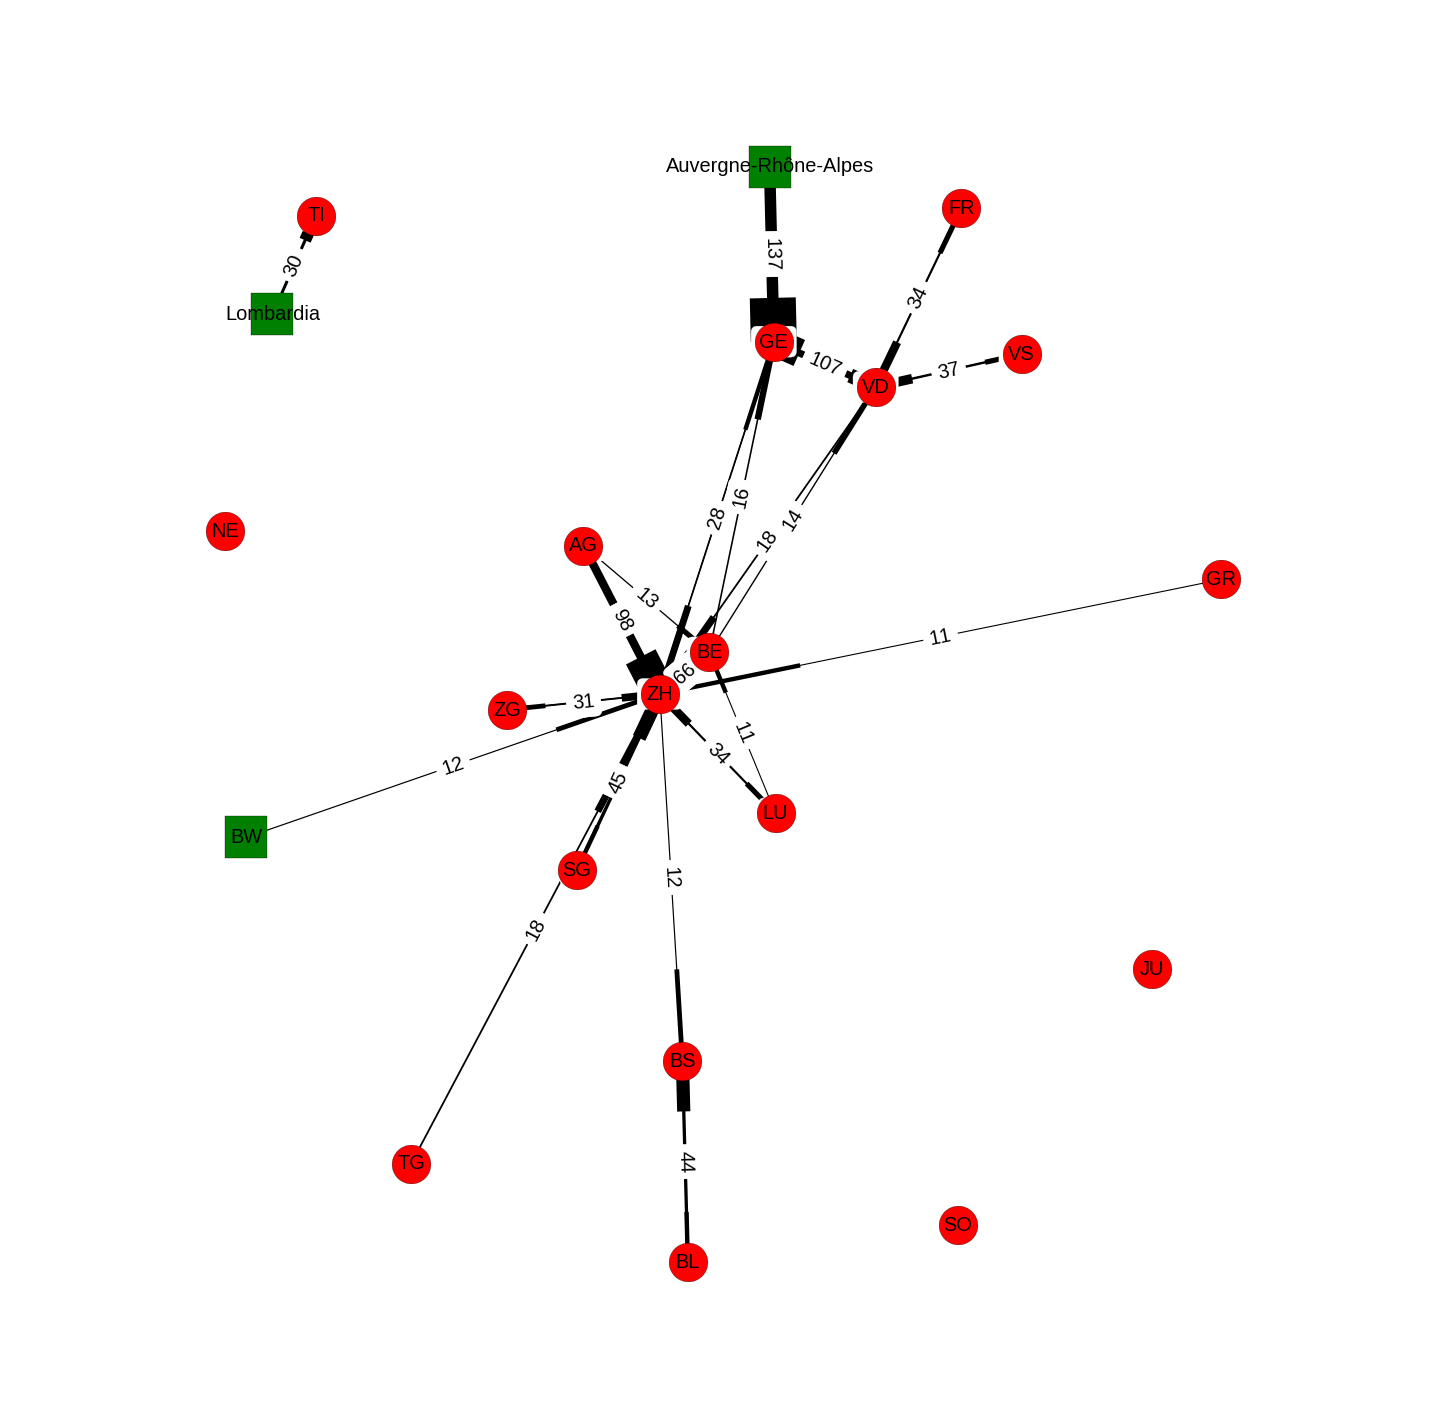

In [19]:
# data to be used in the graph
graph_data = travel_data_grouped[travel_data_grouped['sum'] > threshold].copy()
# reset index
graph_data.reset_index(inplace=True)
graph_data.columns.name = ''
# visualize graph
visualize_graph(graph_data, swiss_cantons, seed=4)